# Sentiment Analysis

## Introduction

In this notebook, our goal is to analyze Twitter's tweets about bitcoin.
We want to see if the general sentiment about bitcoin (by searching tweets with the ticker) reflects the trend of the corrency price (positive sentiments are followed by ascending price and negative sentiments followed by descending price).




In order to check the above, we compare 3 models for text sentiment analysis and discuss the results later in this notebook:
1.   **VADER** Sentiment Analysis (https://github.com/cjhutto/vaderSentiment)
> VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.<br><br>
About the Scoring:<br>
The sentiment property returns a an object of the following form:
```
{'pos': 0.303, 'compound': 0.3832, 'neu': 0.697, 'neg': 0.0}
```
The **compound** score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.<br>
NOTE: The compound score is the one most commonly used for sentiment analysis by most researchers, including the authors.

2.   **TextBlob** (https://textblob.readthedocs.io/en/dev)
> TextBlob is a Python (2 and 3) library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, **sentiment analysis**, classification, translation, and more.<br><br>
The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The **polarity** score is a float within the range [-1.0, 1.0], and this is the value we extract from each tweet. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

3.   The **BERT** language model (learnt in class and implemented on exercise 4)
> BERT, stands for Bidirectional Encoder Representations from Transformers. BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.

---

Run on colab:

In [1]:
!pip install Cython
!pip install whatthelang
!pip install tensorflow
!pip3 install nest_asyncio
!pip install tweet-preprocessor
!pip install twint
!pip3 install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
!pip install --upgrade ipykernel # important
!pip install chart-studio # visualization
!pip install wordcloud
!pip install yfinance
!pip install vaderSentiment
!pip install transformers 
!pip install plotly==5.8
!pip install textblob seaborn nltk
!pip install pyyaml==5.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 786 kB 7.3 MB/s 
     |████████████████████████████████| 871 kB 62.4 MB/s 
     |████████████████████████████████| 244 kB 87.9 MB/s 
  Created wheel for whatthelang: filename=whatthelang-1.0.1-py3-none-any.whl size=789818 sha256=a48d6ac5b64c926db89cbaecc1e1032611130d5d9268bd9935cd0ab1ba0d279f
  Stored in directory: /root/.cache/pip/wheels/91/5b/fe/43b4b1eb6511aed55a9c5ecf3a178a9b06d783a58907dbc87b
  Created wheel for pyfasttext: filename=pyfasttext-0.4.6-cp37-cp37m-linux_x86_64.whl size=1461144 sha256=22f9b02c18f7a4c2305a24224664d5848408c0bed23279456934385de32d1a68
  Stored in directory: /root/.cache/pip/wheels/e6/e7/60/c4506ea3173416f3774e221bd741d06bfc2127ec23ceff6619
Successfully built whatthelang pyfasttext
Looking in indexes: https://pypi.org/simp

---

Use GPU for faster runtime

In [1]:
%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

UsageError: Line magic function `%tensorflow_version` not found.


In [1]:

import pandas as pd
import numpy as np
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
import plotly.graph_objects as go
import plotly.express as px

---

In [2]:
EPSILON = 0.1
TICKER = "BTC"
SEARCH_WORD = f"#{TICKER}"

DATE_SINCE = "2019-05-25"
DATE_UNTIL = "2019-06-24" 
file_name = "BTC_2019-05-25_2019-06-25__tweets_data_from_file_english_no_duplicates_sampe_40K.csv"

---

In [4]:
tweet_data = pd.read_csv("./datasets/" + file_name)

In [6]:
tweet_data.tail()

Unnamed: 0.2  Unnamed: 0.1    index  Unnamed: 0  \
39995        445242        589370   630044     7520827   
39996        940300       1232112  1411308     8308969   
39997       1125309       1480630  1686351     8782003   
39998        319225        426415   455123     7343696   
39999        578039        760710   813465     7706830   

                         date  \
39995  2019-06-02 08:37:00+00   
39996  2019-06-13 17:36:13+00   
39997  2019-06-17 19:25:06+00   
39998  2019-05-30 18:26:29+00   
39999  2019-06-05 00:20:56+00   

                                                   tweet        username  \
39995  ⏰ LIQUIDATION on BTC-PERPETUAL ☠️️\n\n Bought ...     DeribitRekt   
39996  @Lihams22 @BHoarder1 @CalvinAyre @oudekaas3 bt...    missourapete   
39997  Sr Platform Engineer - Veear ( San Jose, Unite...  WorkInRobotics   
39998  Be part of the future App Store https://t.co/D...    Kupi83921604   
39999  @WinthorpeBot Everyone see that  BTC is  start...         koks_05   

       link  retweets  
39995   NaN       0.0  
39996   NaN       0.0  
39997   NaN       0.0  
39998   NaN       0.0  
39999   NaN       0.0

In [7]:
tweet_data

Unnamed: 0.2  Unnamed: 0.1    index  Unnamed: 0  \
0            246275        333135   354812     7242079   
1            986744       1292458  1476476     8374478   
2           1135815       1494023  1820000     8915720   
3            714433        938030  1004903     7900185   
4            575337        757193   809732     7703075   
...             ...           ...      ...         ...   
39995        445242        589370   630044     7520827   
39996        940300       1232112  1411308     8308969   
39997       1125309       1480630  1686351     8782003   
39998        319225        426415   455123     7343696   
39999        578039        760710   813465     7706830   

                         date  \
0      2019-05-29 14:55:00+00   
1      2019-06-14 18:24:23+00   
2      2019-06-17 23:49:06+00   
3      2019-06-08 03:01:57+00   
4      2019-06-04 22:54:29+00   
...                       ...   
39995  2019-06-02 08:37:00+00   
39996  2019-06-13 17:36:13+00   
39997  2019-06-17 19:25:06+00   
39998  2019-05-30 18:26:29+00   
39999  2019-06-05 00:20:56+00   

                                                   tweet         username  \
0      $btg / $btc: +9% value, +267% volume at #Binan...  cryptocoinradar   
1      Cryptocurrency | Cryptocurrency Jewelry | Mens...  ArtHarmony_shop   
2      @GainsPainsCapit @DavidBCollum @mark_dow The s...     paranoidbull   
3      Bitcoin price analysis: 8 june, bitcoin is bul...   ClubInvestlife   
4      @DRomATX Always better to get a bargain price ...         ivanba12   
...                                                  ...              ...   
39995  ⏰ LIQUIDATION on BTC-PERPETUAL ☠️️\n\n Bought ...      DeribitRekt   
39996  @Lihams22 @BHoarder1 @CalvinAyre @oudekaas3 bt...     missourapete   
39997  Sr Platform Engineer - Veear ( San Jose, Unite...   WorkInRobotics   
39998  Be part of the future App Store https://t.co/D...     Kupi83921604   
39999  @WinthorpeBot Everyone see that  BTC is  start...          koks_05   

       link  retweets  
0       NaN       1.0  
1       NaN       0.0  
2       NaN       0.0  
3       NaN       0.0  
4       NaN       0.0  
...     ...       ...  
39995   NaN       0.0  
39996   NaN       0.0  
39997   NaN       0.0  
39998   NaN       0.0  
39999   NaN       0.0  

[40000 rows x 9 columns]

# <u>**Preprocessing**</u>

In [8]:
tweet_data.index = range(len(tweet_data)) # Reindex

In [10]:
tweet_data['tweet'] = tweet_data['tweet'].astype('str')

In [11]:
tweet_data

Unnamed: 0.2  Unnamed: 0.1    index  Unnamed: 0  \
0            246275        333135   354812     7242079   
1            986744       1292458  1476476     8374478   
2           1135815       1494023  1820000     8915720   
3            714433        938030  1004903     7900185   
4            575337        757193   809732     7703075   
...             ...           ...      ...         ...   
39995        445242        589370   630044     7520827   
39996        940300       1232112  1411308     8308969   
39997       1125309       1480630  1686351     8782003   
39998        319225        426415   455123     7343696   
39999        578039        760710   813465     7706830   

                         date  \
0      2019-05-29 14:55:00+00   
1      2019-06-14 18:24:23+00   
2      2019-06-17 23:49:06+00   
3      2019-06-08 03:01:57+00   
4      2019-06-04 22:54:29+00   
...                       ...   
39995  2019-06-02 08:37:00+00   
39996  2019-06-13 17:36:13+00   
39997  2019-06-17 19:25:06+00   
39998  2019-05-30 18:26:29+00   
39999  2019-06-05 00:20:56+00   

                                                   tweet         username  \
0      $btg / $btc: +9% value, +267% volume at #Binan...  cryptocoinradar   
1      Cryptocurrency | Cryptocurrency Jewelry | Mens...  ArtHarmony_shop   
2      @GainsPainsCapit @DavidBCollum @mark_dow The s...     paranoidbull   
3      Bitcoin price analysis: 8 june, bitcoin is bul...   ClubInvestlife   
4      @DRomATX Always better to get a bargain price ...         ivanba12   
...                                                  ...              ...   
39995  ⏰ LIQUIDATION on BTC-PERPETUAL ☠️️\n\n Bought ...      DeribitRekt   
39996  @Lihams22 @BHoarder1 @CalvinAyre @oudekaas3 bt...     missourapete   
39997  Sr Platform Engineer - Veear ( San Jose, Unite...   WorkInRobotics   
39998  Be part of the future App Store https://t.co/D...     Kupi83921604   
39999  @WinthorpeBot Everyone see that  BTC is  start...          koks_05   

       link  retweets  
0       NaN       1.0  
1       NaN       0.0  
2       NaN       0.0  
3       NaN       0.0  
4       NaN       0.0  
...     ...       ...  
39995   NaN       0.0  
39996   NaN       0.0  
39997   NaN       0.0  
39998   NaN       0.0  
39999   NaN       0.0  

[40000 rows x 9 columns]

# Preprocess features

In [12]:
import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.EMOJI)

In [13]:
%%time
tweet_data['text'] = tweet_data['tweet'].apply(lambda x: p.clean(x))

CPU times: user 4.13 s, sys: 39 ms, total: 4.17 s
Wall time: 4.52 s


In [14]:
tweet_data

Unnamed: 0.2  Unnamed: 0.1    index  Unnamed: 0  \
0            246275        333135   354812     7242079   
1            986744       1292458  1476476     8374478   
2           1135815       1494023  1820000     8915720   
3            714433        938030  1004903     7900185   
4            575337        757193   809732     7703075   
...             ...           ...      ...         ...   
39995        445242        589370   630044     7520827   
39996        940300       1232112  1411308     8308969   
39997       1125309       1480630  1686351     8782003   
39998        319225        426415   455123     7343696   
39999        578039        760710   813465     7706830   

                         date  \
0      2019-05-29 14:55:00+00   
1      2019-06-14 18:24:23+00   
2      2019-06-17 23:49:06+00   
3      2019-06-08 03:01:57+00   
4      2019-06-04 22:54:29+00   
...                       ...   
39995  2019-06-02 08:37:00+00   
39996  2019-06-13 17:36:13+00   
39997  2019-06-17 19:25:06+00   
39998  2019-05-30 18:26:29+00   
39999  2019-06-05 00:20:56+00   

                                                   tweet         username  \
0      $btg / $btc: +9% value, +267% volume at #Binan...  cryptocoinradar   
1      Cryptocurrency | Cryptocurrency Jewelry | Mens...  ArtHarmony_shop   
2      @GainsPainsCapit @DavidBCollum @mark_dow The s...     paranoidbull   
3      Bitcoin price analysis: 8 june, bitcoin is bul...   ClubInvestlife   
4      @DRomATX Always better to get a bargain price ...         ivanba12   
...                                                  ...              ...   
39995  ⏰ LIQUIDATION on BTC-PERPETUAL ☠️️\n\n Bought ...      DeribitRekt   
39996  @Lihams22 @BHoarder1 @CalvinAyre @oudekaas3 bt...     missourapete   
39997  Sr Platform Engineer - Veear ( San Jose, Unite...   WorkInRobotics   
39998  Be part of the future App Store https://t.co/D...     Kupi83921604   
39999  @WinthorpeBot Everyone see that  BTC is  start...          koks_05   

       link  retweets                                               text  
0       NaN       1.0  $btg / $btc: +9% value, +267% volume at #Binan...  
1       NaN       0.0  Cryptocurrency | Cryptocurrency Jewelry | Mens...  
2       NaN       0.0  @GainsPainsCapit @DavidBCollum @mark_dow The s...  
3       NaN       0.0  Bitcoin price analysis: 8 june, bitcoin is bul...  
4       NaN       0.0  @DRomATX Always better to get a bargain price ...  
...     ...       ...                                                ...  
39995   NaN       0.0  LIQUIDATION on BTC-PERPETUAL Bought $130 of #B...  
39996   NaN       0.0  @Lihams22 @BHoarder1 @CalvinAyre @oudekaas3 bt...  
39997   NaN       0.0  Sr Platform Engineer - Veear ( San Jose, Unite...  
39998   NaN       0.0  Be part of the future App Store @dapp_com Join...  
39999   NaN       0.0  @WinthorpeBot Everyone see that BTC is startin...  

[40000 rows x 10 columns]

## Vender

In [15]:
analyzer = SentimentIntensityAnalyzer()

In [16]:
#Adding key words from Reddit\Twitter - slang.
new_words = {
    'rocket': 1.0,
    'banana': 1.0,
    'full moon': 1.0,
    'waxing gibbous moon': 1.0,
    'crescent moon': 1.0,
    'to the moon': 1.0,
    'stonk': 1.0,
    'gorila': 1.0,
    'gang': 1.0,
    'bitcoin': 1.0,
    'gme': 1.0,
    'hedge fund': -1.0,
    'crypto': 1.0,
    'Squeeze': 1.0,
    'ApeStrongTogether': 1.0,
    'Apes': 1.0,
    'Ape': 1.0,
    'repos': 1.0,
    'DarkPoolAbuse ': -1.0,
    'dark pool ': -1.0,
    'dark MOASS ': 1.0,
}
analyzer.lexicon.update(new_words)

In [17]:
%%time
tweet_data['vader'] = tweet_data['tweet'].apply(lambda x: analyzer.polarity_scores(x)['compound']) # https://github.com/cjhutto/vaderSentiment


CPU times: user 8.5 s, sys: 79.9 ms, total: 8.58 s
Wall time: 9.63 s


## Textblob

In [18]:
%%time
tweet_data['textblob'] = tweet_data['text'].apply(lambda x: TextBlob(x).polarity)

CPU times: user 15.2 s, sys: 105 ms, total: 15.3 s
Wall time: 16.3 s


In [19]:
tweet_data

Unnamed: 0.2  Unnamed: 0.1    index  Unnamed: 0  \
0            246275        333135   354812     7242079   
1            986744       1292458  1476476     8374478   
2           1135815       1494023  1820000     8915720   
3            714433        938030  1004903     7900185   
4            575337        757193   809732     7703075   
...             ...           ...      ...         ...   
39995        445242        589370   630044     7520827   
39996        940300       1232112  1411308     8308969   
39997       1125309       1480630  1686351     8782003   
39998        319225        426415   455123     7343696   
39999        578039        760710   813465     7706830   

                         date  \
0      2019-05-29 14:55:00+00   
1      2019-06-14 18:24:23+00   
2      2019-06-17 23:49:06+00   
3      2019-06-08 03:01:57+00   
4      2019-06-04 22:54:29+00   
...                       ...   
39995  2019-06-02 08:37:00+00   
39996  2019-06-13 17:36:13+00   
39997  2019-06-17 19:25:06+00   
39998  2019-05-30 18:26:29+00   
39999  2019-06-05 00:20:56+00   

                                                   tweet         username  \
0      $btg / $btc: +9% value, +267% volume at #Binan...  cryptocoinradar   
1      Cryptocurrency | Cryptocurrency Jewelry | Mens...  ArtHarmony_shop   
2      @GainsPainsCapit @DavidBCollum @mark_dow The s...     paranoidbull   
3      Bitcoin price analysis: 8 june, bitcoin is bul...   ClubInvestlife   
4      @DRomATX Always better to get a bargain price ...         ivanba12   
...                                                  ...              ...   
39995  ⏰ LIQUIDATION on BTC-PERPETUAL ☠️️\n\n Bought ...      DeribitRekt   
39996  @Lihams22 @BHoarder1 @CalvinAyre @oudekaas3 bt...     missourapete   
39997  Sr Platform Engineer - Veear ( San Jose, Unite...   WorkInRobotics   
39998  Be part of the future App Store https://t.co/D...     Kupi83921604   
39999  @WinthorpeBot Everyone see that  BTC is  start...          koks_05   

       link  retweets                                               text  \
0       NaN       1.0  $btg / $btc: +9% value, +267% volume at #Binan...   
1       NaN       0.0  Cryptocurrency | Cryptocurrency Jewelry | Mens...   
2       NaN       0.0  @GainsPainsCapit @DavidBCollum @mark_dow The s...   
3       NaN       0.0  Bitcoin price analysis: 8 june, bitcoin is bul...   
4       NaN       0.0  @DRomATX Always better to get a bargain price ...   
...     ...       ...                                                ...   
39995   NaN       0.0  LIQUIDATION on BTC-PERPETUAL Bought $130 of #B...   
39996   NaN       0.0  @Lihams22 @BHoarder1 @CalvinAyre @oudekaas3 bt...   
39997   NaN       0.0  Sr Platform Engineer - Veear ( San Jose, Unite...   
39998   NaN       0.0  Be part of the future App Store @dapp_com Join...   
39999   NaN       0.0  @WinthorpeBot Everyone see that BTC is startin...   

        vader  textblob  
0      0.3400  0.000000  
1      0.0000  0.000000  
2     -0.1779  0.025000  
3      0.0000  0.000000  
4      0.6693  0.175000  
...       ...       ...  
39995 -0.3400  0.000000  
39996  0.0000  0.000000  
39997  0.5859  0.000000  
39998  0.8074  0.133333  
39999  0.5562  0.250000  

[40000 rows x 12 columns]

In [32]:
# tweets_df = df_sub[["date", "text", "textblob", "vader"]]

## BERT

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

# Create a new model instance
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")


tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [20]:
# Restore the weights
# bert_model.load_weights('./models/model_checkpoints/bert_model')
bert_model.load_weights('./models/model_checkpoints/bert_model')

2022-07-29 10:06:03.762107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
%%time
import tensorflow as tf
def Bert_v(x):
    tf_batch = tokenizer(x, max_length=128, padding=True, truncation=True, return_tensors='tf')
    tf_outputs = bert_model(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
    labels = [-1,1]
    label = tf.argmax(tf_predictions, axis=1)
    label = label.numpy()
    return labels[label[0]]
tweet_data['bert'] = np.vectorize(Bert_v)(tweet_data['text'])

2022-07-29 10:06:03.762107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
tweet_data.head()

Unnamed: 0.2  Unnamed: 0.1    index  Unnamed: 0                    date  \
0        246275        333135   354812     7242079  2019-05-29 14:55:00+00   
1        986744       1292458  1476476     8374478  2019-06-14 18:24:23+00   
2       1135815       1494023  1820000     8915720  2019-06-17 23:49:06+00   
3        714433        938030  1004903     7900185  2019-06-08 03:01:57+00   
4        575337        757193   809732     7703075  2019-06-04 22:54:29+00   

                                               tweet         username  link  \
0  $btg / $btc: +9% value, +267% volume at #Binan...  cryptocoinradar   NaN   
1  Cryptocurrency | Cryptocurrency Jewelry | Mens...  ArtHarmony_shop   NaN   
2  @GainsPainsCapit @DavidBCollum @mark_dow The s...     paranoidbull   NaN   
3  Bitcoin price analysis: 8 june, bitcoin is bul...   ClubInvestlife   NaN   
4  @DRomATX Always better to get a bargain price ...         ivanba12   NaN   

   retweets                                               text   vader  \
0       1.0  $btg / $btc: +9% value, +267% volume at #Binan...  0.3400   
1       0.0  Cryptocurrency | Cryptocurrency Jewelry | Mens...  0.0000   
2       0.0  @GainsPainsCapit @DavidBCollum @mark_dow The s... -0.1779   
3       0.0  Bitcoin price analysis: 8 june, bitcoin is bul...  0.0000   
4       0.0  @DRomATX Always better to get a bargain price ...  0.6693   

   textblob  bert  
0     0.000    -1  
1     0.000    -1  
2     0.025    -1  
3     0.000    -1  
4     0.175     1

In [27]:
tweets_sentiment_df = tweet_data[["date", "text", "textblob", "vader", "bert"]]
tweets_sentiment_df

date  \
0      2019-05-29 14:55:00+00   
1      2019-06-14 18:24:23+00   
2      2019-06-17 23:49:06+00   
3      2019-06-08 03:01:57+00   
4      2019-06-04 22:54:29+00   
...                       ...   
39995  2019-06-02 08:37:00+00   
39996  2019-06-13 17:36:13+00   
39997  2019-06-17 19:25:06+00   
39998  2019-05-30 18:26:29+00   
39999  2019-06-05 00:20:56+00   

                                                    text  textblob   vader  \
0      $btg / $btc: +9% value, +267% volume at #Binan...  0.000000  0.3400   
1      Cryptocurrency | Cryptocurrency Jewelry | Mens...  0.000000  0.0000   
2      @GainsPainsCapit @DavidBCollum @mark_dow The s...  0.025000 -0.1779   
3      Bitcoin price analysis: 8 june, bitcoin is bul...  0.000000  0.0000   
4      @DRomATX Always better to get a bargain price ...  0.175000  0.6693   
...                                                  ...       ...     ...   
39995  LIQUIDATION on BTC-PERPETUAL Bought $130 of #B...  0.000000 -0.3400   
39996  @Lihams22 @BHoarder1 @CalvinAyre @oudekaas3 bt...  0.000000  0.0000   
39997  Sr Platform Engineer - Veear ( San Jose, Unite...  0.000000  0.5859   
39998  Be part of the future App Store @dapp_com Join...  0.133333  0.8074   
39999  @WinthorpeBot Everyone see that BTC is startin...  0.250000  0.5562   

       bert  
0        -1  
1        -1  
2        -1  
3        -1  
4         1  
...     ...  
39995     1  
39996     1  
39997    -1  
39998    -1  
39999     1  

[40000 rows x 5 columns]

In [29]:
tweets_sentiment_df.to_csv("./datasets/senitiments_scores.csv")

In [30]:
# Remove textblob values around +-EPSILON from 0 [-EPSILON, +EPSILON]
non_zero_sentiment_df = tweets_sentiment_df[abs(tweets_sentiment_df.textblob) > EPSILON]

non_zero_sentiment_df.head()

date                                               text  \
4   2019-06-04 22:54:29+00  @DRomATX Always better to get a bargain price ...   
5   2019-06-24 01:14:04+00  Someone asked me today if Ill buy a #Lambo whe...   
9   2019-06-23 17:37:30+00  - Bitcoin Price Tops $10K for First Time Since...   
10  2019-06-01 16:56:19+00  Can anyone point me in the direction of a char...   
11  2019-06-20 14:18:50+00  @wikileaks Add Bitcoin Cash donations. I can't...   

    textblob   vader  bert  
4   0.175000  0.6693     1  
5  -0.500000  0.7351    -1  
9   0.250000  0.5106     1  
10  0.250000  0.3400    -1  
11 -0.166667  0.0000    -1

---

# <u>**Visualizations**</u>

## <u>**Histograms**</u>

### <u>**Sentiment/date**</u>

In [1]:
fig1 = px.histogram(tweets_sentiment_df, x="date", y="textblob", histfunc="avg", title='Average <b>TextBlob</b> polarity sentiment scorε per date for tweets containing "#BTC"')
fig1.update_traces(xbins_size="D1")
fig1.update_xaxes(showgrid=True)
fig1.update_layout(bargap=0.1)
fig1.add_trace(go.Scatter(mode="markers", x=tweets_sentiment_df["date"], y=tweets_sentiment_df["textblob"], name="daily"))

fig2 = px.histogram(non_zero_sentiment_df, x="date", y="vader", histfunc="avg", title='Average <b>VADER</b> compound sentiment score per date for tweets containing "#BTC"')
fig2.update_traces(xbins_size="D1")
fig2.update_xaxes(showgrid=True)
fig2.update_layout(bargap=0.1)
fig2.add_trace(go.Scatter(mode="markers", x=non_zero_sentiment_df["date"], y=non_zero_sentiment_df["vader"], name="daily"))

fig3 = px.histogram(non_zero_sentiment_df, x="date", y="bert", histfunc="avg", title='Average <b>ΒΕRΤ</b> sentiment score per date for tweets containing "#BTC"')
fig3.update_traces(xbins_size="D1")
fig3.update_xaxes(showgrid=True)
fig3.update_layout(bargap=0.1)
fig3.add_trace(go.Scatter(mode="markers", x=non_zero_sentiment_df["date"], y=non_zero_sentiment_df["bert"], name="daily"))

fig1.show()
fig2.show()
fig3.show()

NameError: name 'px' is not defined

---

### <u>**Total sentiments count**</u>

In [32]:
fig1 = px.histogram(tweets_sentiment_df, x="textblob", nbins=12)
fig2 = px.histogram(tweets_sentiment_df, x="vader", nbins=12)

fig1.update_layout(
    title={
        'text':'<b>TextBlob</b> polarity sentiments\' scores from bitcoin tweets',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor':'top'
        },
    xaxis_title="Sentiment score",
    yaxis_title="Count")

fig2.update_layout(
    title={
        'text':'<b>VADER</b> compound sentiments\' scores from tweets containing "#BTC"',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor':'top'
        },
    xaxis_title="Sentiment score",
    yaxis_title="Count")

fig3.update_layout(
    title={
        'text':'<b>BERT</b> sentiments\' scores from tweets containing "#BTC"',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor':'top'
        },
    xaxis_title="Sentiment score",
    yaxis_title="Count")

fig1.show()
fig2.show()
fig3.show()

The histograms above display the distribution of sentiment values (polarity, vader, and bert) for tweets with the given ticker (e.g. "#XXX").

To get better visuals of the sentiment values, it can be helpful to remove the values around zero and create a break in the histograms there:

In [35]:
fig1 = px.histogram(non_zero_sentiment_df, x="textblob", nbins=12)
fig2 = px.histogram(non_zero_sentiment_df, x="vader", nbins=12)
fig3 = px.histogram(non_zero_sentiment_df, x="bert", nbins=12)

fig1.update_layout(
    title={
        'text':'<b>TextBlob</b> polarity sentiments from tweets containing "#BTC" (non-zero sentiments)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor':'top'
        },
    xaxis_title="Sentiment score",
    yaxis_title="Count")

fig2.update_layout(
    title={
        'text':'<b>VADER</b> compound sentiments\' scores from tweets containing "#BTC" (non-zero sentiments)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor':'top'
        },
    xaxis_title="Sentiment score",
    yaxis_title="Count")

fig3.update_layout(
    title={
        'text':'<b>BERT</b> sentiments\' scores from tweets containing "#BTC" (non-zero sentiments)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor':'top'
        },
    xaxis_title="Sentiment score",
    yaxis_title="Count")

fig1.add_shape(
        go.layout.Shape(type='line', xref='x', yref='paper',
                        x0=0, y0=0, x1=0, y1=0.9, line={'dash': 'dash'}),
)

fig2.add_shape(
        go.layout.Shape(type='line', xref='x', yref='paper',
                        x0=0, y0=0, x1=0, y1=0.9, line={'dash': 'dash'}),
)

fig3.add_shape(
        go.layout.Shape(type='line', xref='x', yref='paper',
                        x0=0, y0=0, x1=0, y1=0.9, line={'dash': 'dash'}),
)

fig1.show()
fig2.show()
fig3.show()

For these histograms, sentiment values (polarity/vader) around zero [-EPSILON, EPSILON] have been removed, and a break has been added at zero, to better highlight the distribution of sentiment values.

We can see that VADER's compound attribute separates the sentiments more clearly, and we can quickly deduce the general sentiment (positive/negative).

---

# <u>**Get average sentiment score per date**</u>

In this section, we group the sentiment per date, and keep the average sentiment score for polarity and VADER.
For the BERT value, we take the average between all positive and negative labels and define it as the sentiment score for this feature.

In [36]:
avg_df = non_zero_sentiment_df.copy()
avg_df['date'] = pd.to_datetime(avg_df['date'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')
avg_df = avg_df.rename(columns={'date': 'Date'})
avg_df = avg_df.set_index('Date')
avg_df

text  textblob  \
Date                                                                      
2019-06-04  @DRomATX Always better to get a bargain price ...  0.175000   
2019-06-24  Someone asked me today if Ill buy a #Lambo whe... -0.500000   
2019-06-23  - Bitcoin Price Tops $10K for First Time Since...  0.250000   
2019-06-01  Can anyone point me in the direction of a char...  0.250000   
2019-06-20  @wikileaks Add Bitcoin Cash donations. I can't... -0.166667   
...                                                       ...       ...   
2019-05-27  LIVE at 5:15PM Baltimore time- The 1 #Bitcoin ...  0.266335   
2019-06-08  New Free Bitcoin CLOUD MINING Site 2019. Earn ...  0.268182   
2019-06-22  @valkenburgh @stephendpalley Bitcoin is exclud...  0.166667   
2019-05-30  Be part of the future App Store @dapp_com Join...  0.133333   
2019-06-05  @WinthorpeBot Everyone see that BTC is startin...  0.250000   

             vader  bert  
Date                      
2019-06-04  0.6693     1  
2019-06-24  0.7351    -1  
2019-06-23  0.5106     1  
2019-06-01  0.3400    -1  
2019-06-20  0.0000    -1  
...            ...   ...  
2019-05-27  0.4168    -1  
2019-06-08  0.5106    -1  
2019-06-22 -0.5106    -1  
2019-05-30  0.8074    -1  
2019-06-05  0.5562     1  

[17762 rows x 4 columns]

# Get average sentiment value (polarity/VADER) per day

In [37]:
avg_df = avg_df.groupby(['Date']).mean().reset_index().set_index('Date')
avg_df

textblob     vader      bert
Date                                    
2019-05-25  0.264886  0.388306 -0.084079
2019-05-26  0.234687  0.350146 -0.080074
2019-05-27  0.260737  0.319692 -0.039724
2019-05-28  0.226048  0.347650 -0.125767
2019-05-29  0.240057  0.391482 -0.201133
2019-05-30  0.209241  0.365901 -0.246659
2019-05-31  0.216181  0.333268 -0.233129
2019-06-01  0.270167  0.419531 -0.092827
2019-06-02  0.264592  0.366745 -0.183044
2019-06-03  0.236593  0.336494 -0.245009
2019-06-04  0.259919  0.359807 -0.148479
2019-06-05  0.214052  0.317753 -0.215094
2019-06-06  0.194429  0.346026 -0.192661
2019-06-07  0.225692  0.313036 -0.200000
2019-06-08  0.244155  0.330952 -0.177057
2019-06-09  0.243143  0.375963 -0.146530
2019-06-10  0.261024  0.391666 -0.171247
2019-06-11  0.231733  0.339913 -0.177914
2019-06-12  0.256760  0.362202 -0.124760
2019-06-13  0.241239  0.380621 -0.141264
2019-06-14  0.244952  0.336286 -0.184906
2019-06-15  0.256939  0.366097 -0.124682
2019-06-16  0.239780  0.345043 -0.210238
2019-06-17  0.238630  0.347784 -0.142384
2019-06-18  0.237853  0.345563 -0.197531
2019-06-19  0.251160  0.380749 -0.210345
2019-06-20  0.245230  0.368257 -0.239243
2019-06-21  0.231907  0.340908 -0.162667
2019-06-22  0.215672  0.307717 -0.262181
2019-06-23  0.264685  0.343344 -0.144312
2019-06-24  0.256142  0.336160 -0.144560

# <u>**Yahoo Finance**</u>

We scatter the price for the specific ticker and compare it to next to the sentiments scores per day

In [38]:
import yfinance as yf
import datetime
import time
import requests
import io

In [39]:
since_date = datetime.datetime.strptime("2019-05-25", '%Y-%m-%d')
TODAY = datetime.datetime.strptime("2019-06-24", '%Y-%m-%d')

In [40]:
DATE_SINCE,DATE_UNTIL

('2019-05-25', '2019-06-24')

In [41]:
# create empty dataframe
stock_final = pd.DataFrame()

# iterate over each symbol
assets = ['BTC-USD']

for i in assets:
    # print the symbol which is being downloaded
    print( str(assets.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=since_date, end=TODAY, progress=False)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['Name'] = i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None

0 : BTC-USD,

Below, we attach the ticker's closing price per date to our avg_df

In [42]:
final_df = stock_final[["Adj Close"]].rename(columns={"Adj Close": "price"}).astype(float)
final_df = final_df.reset_index()
final_df['Date'] = pd.to_datetime(final_df['Date']).dt.strftime('%Y-%m-%d')
final_df = final_df.set_index('Date')


In [43]:
x = pd.DataFrame(final_df.price.diff())
x['diff_sign'] = np.sign(x.price)
x=x.drop(columns=["price"])

In [44]:
result = pd.concat([final_df,x, avg_df], axis=1, join="inner")
result

price  diff_sign  textblob     vader      bert
Date                                                             
2019-05-25   8052.543945        1.0  0.264886  0.388306 -0.084079
2019-05-26   8673.215820        1.0  0.234687  0.350146 -0.080074
2019-05-27   8805.778320        1.0  0.260737  0.319692 -0.039724
2019-05-28   8719.961914       -1.0  0.226048  0.347650 -0.125767
2019-05-29   8659.487305       -1.0  0.240057  0.391482 -0.201133
2019-05-30   8319.472656       -1.0  0.209241  0.365901 -0.246659
2019-05-31   8574.501953        1.0  0.216181  0.333268 -0.233129
2019-06-01   8564.016602       -1.0  0.270167  0.419531 -0.092827
2019-06-02   8742.958008        1.0  0.264592  0.366745 -0.183044
2019-06-03   8208.995117       -1.0  0.236593  0.336494 -0.245009
2019-06-04   7707.770996       -1.0  0.259919  0.359807 -0.148479
2019-06-05   7824.231445        1.0  0.214052  0.317753 -0.215094
2019-06-06   7822.023438       -1.0  0.194429  0.346026 -0.192661
2019-06-07   8043.951172        1.0  0.225692  0.313036 -0.200000
2019-06-08   7954.127930       -1.0  0.244155  0.330952 -0.177057
2019-06-09   7688.077148       -1.0  0.243143  0.375963 -0.146530
2019-06-10   8000.329590        1.0  0.261024  0.391666 -0.171247
2019-06-11   7927.714355       -1.0  0.231733  0.339913 -0.177914
2019-06-12   8145.857422        1.0  0.256760  0.362202 -0.124760
2019-06-13   8230.923828        1.0  0.241239  0.380621 -0.141264
2019-06-14   8693.833008        1.0  0.244952  0.336286 -0.184906
2019-06-15   8838.375000        1.0  0.256939  0.366097 -0.124682
2019-06-16   8994.488281        1.0  0.239780  0.345043 -0.210238
2019-06-17   9320.352539        1.0  0.238630  0.347784 -0.142384
2019-06-18   9081.762695       -1.0  0.237853  0.345563 -0.197531
2019-06-19   9273.521484        1.0  0.251160  0.380749 -0.210345
2019-06-20   9527.160156        1.0  0.245230  0.368257 -0.239243
2019-06-21  10144.556641        1.0  0.231907  0.340908 -0.162667
2019-06-22  10701.691406        1.0  0.215672  0.307717 -0.262181
2019-06-23  10855.371094        1.0  0.264685  0.343344 -0.144312

In [45]:
result_conf = result.copy()

In [46]:
result_conf['textblob'] = np.sign(result_conf.textblob)
result_conf['vader'] = np.sign(result_conf.vader)
result_conf['bert'] = np.sign(result_conf.bert)
result_conf[result_conf < 0] = 0
result_conf

price  diff_sign  textblob  vader  bert
Date                                                      
2019-05-25   8052.543945        1.0       1.0    1.0   0.0
2019-05-26   8673.215820        1.0       1.0    1.0   0.0
2019-05-27   8805.778320        1.0       1.0    1.0   0.0
2019-05-28   8719.961914        0.0       1.0    1.0   0.0
2019-05-29   8659.487305        0.0       1.0    1.0   0.0
2019-05-30   8319.472656        0.0       1.0    1.0   0.0
2019-05-31   8574.501953        1.0       1.0    1.0   0.0
2019-06-01   8564.016602        0.0       1.0    1.0   0.0
2019-06-02   8742.958008        1.0       1.0    1.0   0.0
2019-06-03   8208.995117        0.0       1.0    1.0   0.0
2019-06-04   7707.770996        0.0       1.0    1.0   0.0
2019-06-05   7824.231445        1.0       1.0    1.0   0.0
2019-06-06   7822.023438        0.0       1.0    1.0   0.0
2019-06-07   8043.951172        1.0       1.0    1.0   0.0
2019-06-08   7954.127930        0.0       1.0    1.0   0.0
2019-06-09   7688.077148        0.0       1.0    1.0   0.0
2019-06-10   8000.329590        1.0       1.0    1.0   0.0
2019-06-11   7927.714355        0.0       1.0    1.0   0.0
2019-06-12   8145.857422        1.0       1.0    1.0   0.0
2019-06-13   8230.923828        1.0       1.0    1.0   0.0
2019-06-14   8693.833008        1.0       1.0    1.0   0.0
2019-06-15   8838.375000        1.0       1.0    1.0   0.0
2019-06-16   8994.488281        1.0       1.0    1.0   0.0
2019-06-17   9320.352539        1.0       1.0    1.0   0.0
2019-06-18   9081.762695        0.0       1.0    1.0   0.0
2019-06-19   9273.521484        1.0       1.0    1.0   0.0
2019-06-20   9527.160156        1.0       1.0    1.0   0.0
2019-06-21  10144.556641        1.0       1.0    1.0   0.0
2019-06-22  10701.691406        1.0       1.0    1.0   0.0
2019-06-23  10855.371094        1.0       1.0    1.0   0.0

In [47]:
from sklearn.metrics import recall_score,accuracy_score,precision_score

In [49]:
for x in ['textblob','vader','bert']:
    y_true, y_pred = result_conf['diff_sign'], result_conf[x]
    print("{0} pridictor:\n{1}".format(x,(tf.math.confusion_matrix(y_true, y_pred))))
    print("Accuracy:\t\t{0}".format(accuracy_score(y_true, y_pred)))
    print("Recall:\t\t\t{0}".format(recall_score(y_true, y_pred)))
    print("precision:\t\t{0}\n".format(precision_score(y_true, y_pred)))

textblob pridictor:
[[ 0 11]
 [ 0 19]]
Accuracy:		0.6333333333333333
Recall:			1.0
precision:		0.6333333333333333

vader pridictor:
[[ 0 11]
 [ 0 19]]
Accuracy:		0.6333333333333333
Recall:			1.0
precision:		0.6333333333333333

bert pridictor:
[[11  0]
 [19  0]]
Accuracy:		0.36666666666666664
Recall:			0.0
precision:		0.0



## Plotting the price history for the ticker over the last X days:

In [52]:
stock = yf.Ticker(TICKER)

# get bitcoing info
print(stock.info)

# get historical market data
hist = stock.history(period="100D")

{'exchange': 'PCX', 'shortName': 'ClearShares Piton Intermediate ', 'longName': 'ClearShares Piton Intermediate Fixed Income ETF', 'exchangeTimezoneName': 'America/New_York', 'exchangeTimezoneShortName': 'EDT', 'isEsgPopulated': False, 'gmtOffSetMilliseconds': '-14400000', 'quoteType': 'ETF', 'symbol': 'BTC', 'messageBoardId': 'finmb_683247102', 'market': 'us_market', 'annualHoldingsTurnover': None, 'enterpriseToRevenue': None, 'beta3Year': None, 'profitMargins': None, 'enterpriseToEbitda': None, '52WeekChange': None, 'morningStarRiskRating': None, 'forwardEps': None, 'revenueQuarterlyGrowth': None, 'fundInceptionDate': 1601510400, 'annualReportExpenseRatio': None, 'totalAssets': 32238336, 'bookValue': None, 'fundFamily': 'ClearShares', 'lastFiscalYearEnd': None, 'netIncomeToCommon': None, 'trailingEps': None, 'lastDividendValue': None, 'SandP52WeekChange': None, 'priceToBook': None, 'nextFiscalYearEnd': None, 'yield': None, 'mostRecentQuarter': None, 'enterpriseValue': None, 'priceHin

<AxesSubplot:xlabel='Date'>

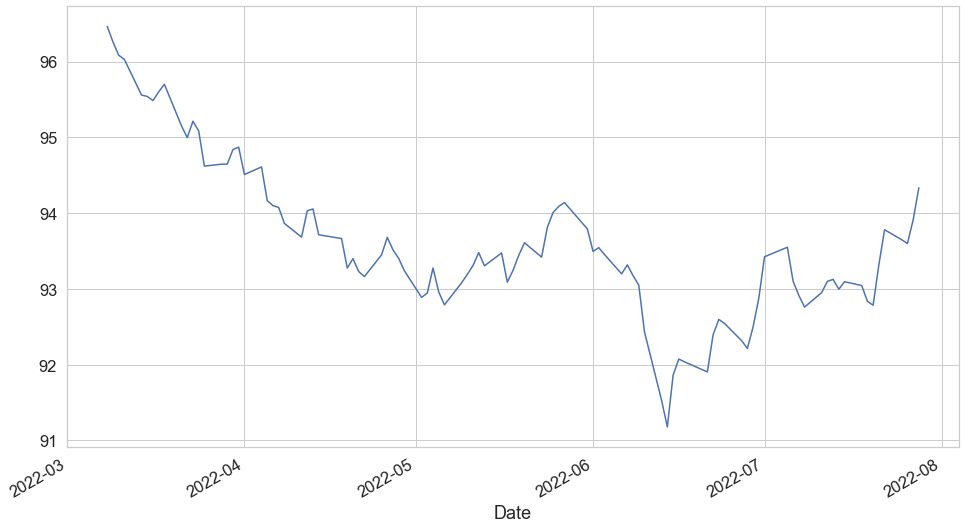

In [53]:
# Plot everything by leveraging the very powerful matplotlib package
hist['Close'].plot(figsize=(16, 9))

# <u>**Experimental results**</u>

## The comparison plot

In [54]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

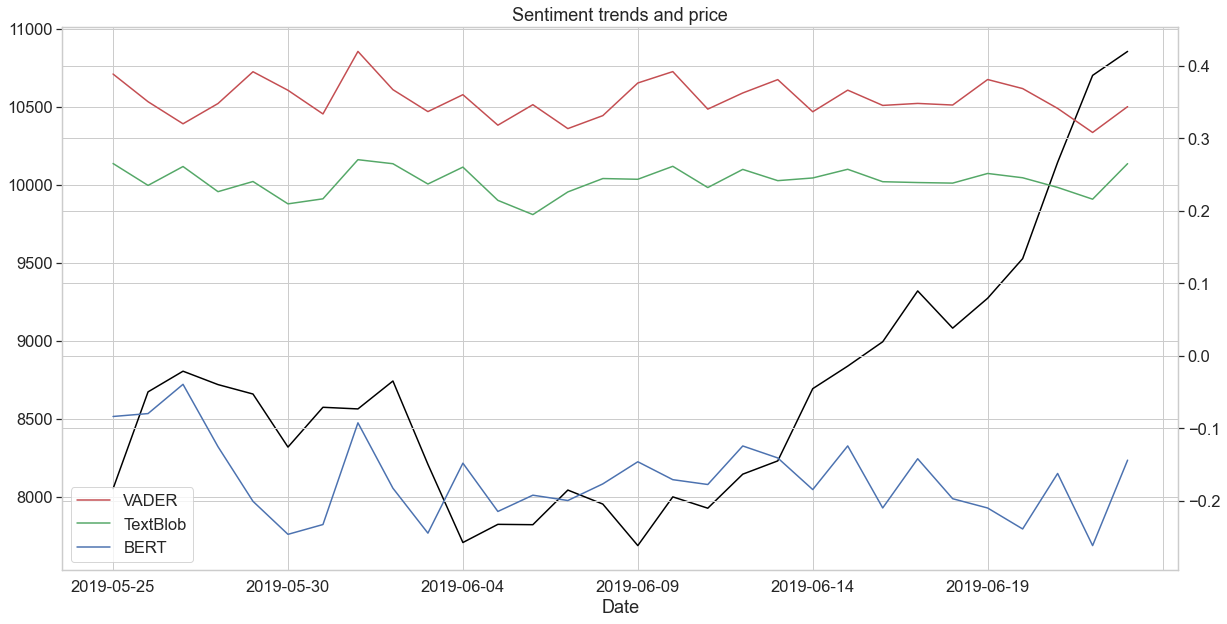

In [55]:
ax = result['price'].plot(color='black', label='price').twinx()
ax2 = result['vader'].plot(color='r', label='VADER')
ax3 = result['textblob'].plot(color='g', label='TextBlob')
ax4 = result['bert'].plot(color='b', label='BERT')

plt.xlabel('date')
plt.title('Sentiment trends and price')
plt.legend()
plt.show()

## Discussion

In figure 1 we see that all 3 models' sentiment measures averages are highly ("Spearman") correlated to one another (generally ascend/descend together) but are (unfortunately) not generally correlated with the actual price (in black).

The only difference is that VADER and TextBlob average scores are mostly positive (larger than 0) and BERT's are mostly negative  (smaller than 0). This can explain the differences in the Confusion Matrices.

It is worth mentioning that we trained the BERT model on IMDB movie critics, and this can be the main cause for the different scores with the other models. We used this training data because this was the closest example we've found (critics on movies as an example of critics on stocks).
We DID actually find a Twitter dataset but it was too large to train upon (15M entries).

The hypothesis of the bitcoin price being highly influenced by social media does not hold vacuously.\\
We assume there are other variables which are also taking place.
For example, the Stock's Index, employment rate, the company's earning, etc.